In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
DATA_FOLDER = "../data"
ABUNDANCE_FILE = "abundance_with_unique.csv"
ABUNDANCE_START = 212

PERCENT_INFO = 0.95
TEST_SPLIT = 0.2
SEED = 42

BATCH_SIZE = 32
LAYERS = [1024, 512, 256, 128, 64, 64, 32, 32]
LEARNING_RATE = 0.00005

In [3]:
abundance_data = pd.read_csv(
    os.path.join(DATA_FOLDER, ABUNDANCE_FILE), low_memory=False
)

In [4]:
metadata = abundance_data.iloc[:, :ABUNDANCE_START]
abundance = abundance_data.iloc[:, ABUNDANCE_START:]

In [5]:
scalar = StandardScaler()
abundance_X_scaled = scalar.fit_transform(abundance)

In [6]:
pca = PCA()
abundance_X_pca = pca.fit_transform(abundance_X_scaled)

(3302,)


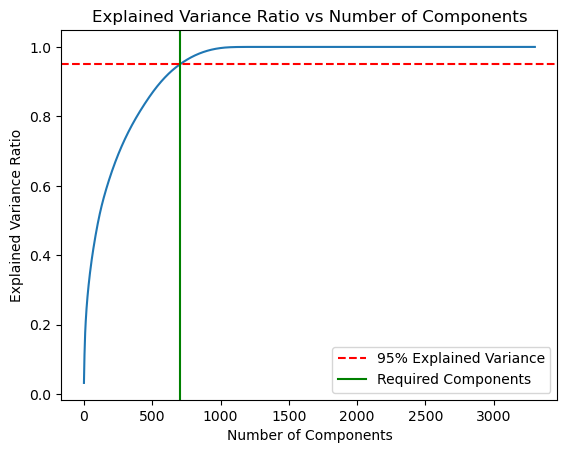

In [7]:
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance_ratio_cumulative.shape)

plt.plot(explained_variance_ratio_cumulative)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Number of Components")

# Plot a line at 0.95 in the y-axis
plt.axhline(y=PERCENT_INFO, color="r", linestyle="--", label="95% Explained Variance")
plt.axvline(
    x=np.argmax(explained_variance_ratio_cumulative > PERCENT_INFO),
    color="g",
    linestyle="-",
    label="Required Components",
)
plt.legend(loc="best")
plt.show()

In [8]:
num_components = np.argmax(explained_variance_ratio_cumulative >= PERCENT_INFO) + 1

print(
    "The number of components to explain {}% of the variance is {}".format(
        PERCENT_INFO * 100, num_components
    )
)
print(
    "The percent of num comps in total comps is {}".format(
        num_components / len(pca.explained_variance_ratio_) * 100
    )
)

The number of components to explain 95.0% of the variance is 705
The percent of num comps in total comps is 21.350696547546942


In [9]:
abundance_top_components = abundance_X_pca[:, :num_components]
print(abundance_top_components.shape)

(3610, 705)


In [10]:
# Create new column in metadata with the new disease names
metadata["disease_new"] = metadata["disease"].apply(
    lambda x: "healthy"
    if x in ["n", "nd", " -", "leaness", "n_relative", "-"]
    else "psoriasis"
    if x == "y"
    else x
)

In [12]:
class AbundanceDataset(Dataset):
    def __init__(self, abundance_data, metadata, classes):
        self.abundance_data = abundance_data
        self.metadata = metadata
        self.classes = classes
        self.n_classes = len(classes)

    def __len__(self):
        return len(self.abundance_data)

    def __getitem__(self, idx):
        target = self.metadata["disease_new"].iloc[idx]
        # Get index of target in classes: np.ndarray
        target = np.where(self.classes == target)[0][0]
        return torch.tensor(
            self.abundance_data[idx], dtype=torch.float32
        ), torch.tensor(target, dtype=torch.long)

In [13]:
from sklearn.model_selection import train_test_split

abundance_train, abundance_test, metadata_train, metadata_test = train_test_split(
    abundance_top_components, metadata, test_size=TEST_SPLIT, random_state=SEED
)

In [14]:
classes = metadata["disease_new"].unique()

dataset_train = AbundanceDataset(abundance_train, metadata_train, classes)
dataset_test = AbundanceDataset(abundance_test, metadata_test, classes)

In [15]:
print(classes)

['healthy' 'obesity' 'stec2-positive' 'ibd_ulcerative_colitis'
 'ibd_crohn_disease' 'psoriasis' 'cirrhosis' 'obese' 'overweight'
 'underweight' 't2d' 'impaired_glucose_tolerance' 'cancer' 'small_adenoma'
 'large_adenoma']


In [23]:
# Print count of each class in train and test combined

value_counts = metadata["disease_new"].value_counts()

for c in classes:
    print(
        "\\texttt{",
        f"{c}",
        "}",
        f"& {value_counts[c]} & {value_counts[c] / len(metadata) * 100:.2f}\\% \\\\",
    )

\texttt{ healthy } & 2692 & 74.57\% \\
\texttt{ obesity } & 164 & 4.54\% \\
\texttt{ stec2-positive } & 52 & 1.44\% \\
\texttt{ ibd_ulcerative_colitis } & 148 & 4.10\% \\
\texttt{ ibd_crohn_disease } & 25 & 0.69\% \\
\texttt{ psoriasis } & 36 & 1.00\% \\
\texttt{ cirrhosis } & 118 & 3.27\% \\
\texttt{ obese } & 5 & 0.14\% \\
\texttt{ overweight } & 10 & 0.28\% \\
\texttt{ underweight } & 1 & 0.03\% \\
\texttt{ t2d } & 223 & 6.18\% \\
\texttt{ impaired_glucose_tolerance } & 49 & 1.36\% \\
\texttt{ cancer } & 48 & 1.33\% \\
\texttt{ small_adenoma } & 26 & 0.72\% \\
\texttt{ large_adenoma } & 13 & 0.36\% \\


In [35]:
class MLP(nn.Module):
    def __init__(self, idim, odim, layers, batch_norm=True):
        super(MLP, self).__init__()
        self.layers = nn.Sequential()
        
        for i, layer in enumerate(layers):
            if i == 0:
                self.layers.add_module("fc{}".format(i), nn.Linear(idim, layer))
            else:
                self.layers.add_module("fc{}".format(i), nn.Linear(layers[i-1], layer))
            
            if batch_norm:
                self.layers.add_module("bn{}".format(i), nn.BatchNorm1d(layer))
            
            self.layers.add_module("relu{}".format(i), nn.ReLU())
            
        self.layers.add_module("fc{}".format(len(layers)), nn.Linear(layers[-1], odim))
        self.layers.add_module("softmax", nn.Softmax(dim=1))
        
    def forward(self, x):
        return self.layers(x)

In [36]:
# Training

def train(model, data_loader, criterion, optimizer):
    """
    Generic training function
    """
    model.train() # Set model to training mode
    running_loss = 0.0
    for _, data in enumerate(data_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # Zero the gradients
        
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
        
        running_loss += loss.item()
    return running_loss / len(data_loader)

def evaluate(model, data_loader, criterion):
    """
    Generic evaluation function    
    """
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for _, data in enumerate(data_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(data_loader), correct / total, true_labels, predicted_labels

In [37]:
def train_one_model(params):
    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    
    model = MLP(abundance_top_components.shape[1], len(classes), params['layers']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    
    for epoch in range(params['epochs']):
        train_loss = train(model, dataloader_train, criterion, optimizer)
        
        if(epoch % 100 == 0):
            print("Epoch {}: Train Loss: {}".format(epoch, train_loss))
            
    train_loss, train_accuracy, train_true_labels, train_predicted_labels = evaluate(model, dataloader_train, criterion)
    test_loss, test_accuracy, test_true_labels, test_predicted_labels = evaluate(model, dataloader_test, criterion)

    return train_loss, train_accuracy, test_loss, test_accuracy

In [38]:
hyperparameters = {
    'batch_size': [32, 16, 8],
    'lr': [0.0001, 0.00005, 0.00001],
    'layers':[
        [1024, 512, 256, 128],
        [1024, 512, 256, 128, 64, 64, 32, 32],
        [1024, 512, 256, 128, 64, 64, 32],
        [1024, 512, 256, 128, 64, 64],
        [1024, 512, 256, 128, 64]
    ],
    'epochs': [200, 300, 400, 500]
}

In [39]:
results = []

import os
import json

OUTPUT_FILE = "../logs/results-mlp-pca-class.json"

if os.path.exists(OUTPUT_FILE):
    with open(OUTPUT_FILE, 'r') as f:
        results = json.load(f)
        
import itertools

for batch_size, lr, layers, epochs in itertools.product(hyperparameters['batch_size'], hyperparameters['lr'], hyperparameters['layers'], hyperparameters['epochs']):
    params = {
        'batch_size': batch_size,
        'lr': lr,
        'layers': layers,
        'epochs': epochs
    }
    print(params)
    
    if any(d['params'] == params for d in results):
        print("Skipping, already done")
        continue
    
    train_loss, train_accuracy, test_loss, test_accuracy = train_one_model(params)
    
    results.append({
        'params': params,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })
    
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(results, f)

{'batch_size': 32, 'lr': 0.0001, 'layers': [1024, 512, 256, 128], 'epochs': 200}


Epoch 0: Train Loss: 2.5915309675447236
Epoch 100: Train Loss: 1.8427246547007299
